v1: last activation changed to softmax

The EDA is done in a [separate Kernel](https://www.kaggle.com/maxlenormand/first-eda-to-get-started)

This is the first iterations I am doing, simply to have a relevant predicted output. Future work will consist of improving this along multiple aspects.

Updates to do to improve performances:
- take into account different image sizes
- perform data augmentation (but not all images can be augmented the same way. Ex: portrait cannot  be flipped vertically. Some abstract objects / representations could).

In [1]:
import numpy as np 
import pandas as pd

import random
import datetime
import seaborn as sns

from keras.models import Sequential
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense,Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.losses import binary_crossentropy
from keras import regularizers, optimizers
from keras.optimizers import Adam

from keras.applications import ResNet50
#from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.vgg19 import VGG19
from keras.applications.mobilenet import MobileNet
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.vgg16 import VGG16
from keras.applications.nasnet import NASNetMobile


from keras.callbacks import ModelCheckpoint,EarlyStopping,CSVLogger,ReduceLROnPlateau

import matplotlib.pyplot as plt

import os
print(os.listdir("../input"))

def append_ext(fn):
    return fn+".png"

def remove_ext(fn):
    return fn[:-4]

Using TensorFlow backend.


['inceptionresnetv2', 'imet-2019-fgvc6', 'vgg19']


In order to compare the performances of models, it is important to seed everything. This means random and numpy, but also tensorflow and Keras. The following code was taken from [this article](https://towardsdatascience.com/properly-setting-the-random-seed-in-machine-learning-experiments-7da298d1320b) from Cecelia Shao. The article is worth a read for a more in depth look of the effects of correctly seeding.

In [2]:
# Set a seed value
seed_value= 7 

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)
# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.set_random_seed(seed_value)
# 5 Configure a new global `tensorflow` session
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [3]:
train_labels=pd.read_csv('../input/imet-2019-fgvc6/train.csv', dtype=str)
#Changing the attribute ids into lists instead of str seperated by a ' ' to be able to count them
train_labels['attribute_ids']=train_labels['attribute_ids'].str.split(' ')
train_labels["id"]=train_labels["id"].apply(append_ext)

test_labels=pd.read_csv('../input/imet-2019-fgvc6/sample_submission.csv', dtype=str)
test_labels["id"]=test_labels["id"].apply(append_ext)

print('train : \n', train_labels.head())
print('\ntest : \n', test_labels.head())

print('\ntrain shape: ', len(train_labels))
print('\ntest shape: ', len(test_labels))

train : 
                      id              attribute_ids
0  1000483014d91860.png            [147, 616, 813]
1  1000fe2e667721fe.png        [51, 616, 734, 813]
2  1001614cb89646ee.png                      [776]
3  10041eb49b297c08.png  [51, 671, 698, 813, 1092]
4  100501c227f8beea.png  [13, 404, 492, 903, 1093]

test : 
                      id attribute_ids
0  10023b2cc4ed5f68.png         0 1 2
1  100fbe75ed8fd887.png         0 1 2
2  101b627524a04f19.png         0 1 2
3  10234480c41284c6.png         0 1 2
4  1023b0e2636dcea8.png         0 1 2

train shape:  109237

test shape:  7443


In [4]:
labels = pd.read_csv('../input/imet-2019-fgvc6/labels.csv', dtype=str)
print('labels : ', '\n', labels.head())

print('\nlabels len :', len(labels))

labels :  
   attribute_id          attribute_name
0            0        culture::abruzzi
1            1     culture::achaemenid
2            2         culture::aegean
3            3         culture::afghan
4            4  culture::after british

labels len : 1103


In [5]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.2)

In [6]:
B_size = 128
Target_size = (96,96) 

train_generator=datagen.flow_from_dataframe(
                                            dataframe=train_labels,
                                            directory="../input/imet-2019-fgvc6/train/",
                                            x_col="id",
                                            y_col="attribute_ids",
                                            subset="training",
                                            batch_size=B_size,
                                            seed=seed_value,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=Target_size
)

valid_generator=datagen.flow_from_dataframe(
                                            dataframe=train_labels,
                                            directory="../input/imet-2019-fgvc6/train/",
                                            x_col="id",
                                            y_col="attribute_ids",
                                            subset="validation",
                                            batch_size=B_size,
                                            seed=seed_value,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=Target_size
)

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
                                                dataframe=test_labels,
                                                directory="../input/imet-2019-fgvc6/test/",
                                                x_col="id",
                                                y_col=None,
                                                batch_size=B_size,
                                                seed=seed_value,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=Target_size
)

Found 87390 images belonging to 1103 classes.
Found 21847 images belonging to 1103 classes.
Found 7443 images.


In [7]:
train_generator.n//train_generator.batch_size

682

focal loss taken from [this Kernel from KeepLearning](https://www.kaggle.com/mathormad/resnet50-v2-keras-focal-loss-mix-up)

In [8]:
gamma = 2.0
epsilon = K.epsilon()
def focal_loss(y_true, y_pred):
    pt = y_pred * y_true + (1-y_pred) * (1-y_true)
    pt = K.clip(pt, epsilon, 1-epsilon)
    CE = -K.log(pt)
    FL = K.pow(1-pt, gamma) * CE
    loss = K.sum(FL, axis=1)
    return loss

f2_score taken from [this Kernel from Alexander Teplyuk](https://www.kaggle.com/ateplyuk/keras-starter)

In [9]:
def f2_score(y_true, y_pred):
    beta = 2
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=1)
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=1)
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=1)
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    return K.mean(((1+beta**2)*precision*recall) / ((beta**2)*precision+recall+K.epsilon()))

In [10]:
#Callbacks

checkpoint = ModelCheckpoint(filepath='weights_test.hdf5',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          mode='auto')

In [11]:
def make_model(model_choice, model_name, input_tensor, weights_link, nb_epoch):
    '''Function to create a model
    Input:
    - model_choice          for ex: VGG19(include_top=False, input_tensor=input_tensor)
    - model_name            (str), name that will be given to the model in tensorboard
    - input_tensor          Input(width_image, height_image, nb_channels)
    - weights_link          (str) since no internet, link to the dataset with weights
    - nb_epoch              (int) number of epoch to train on
    
    Output:
    - model made with keras.model.Model'''
    
    base_model = model_choice
    base_model.load_weights(weights_link)
    base_model.trainable = False
    x = base_model(input_tensor)
    out = Flatten()(x)
    out = Dense(1103, activation="softmax")(out)
    model = Model(input_tensor, out)
    
    model.compile(optimizer=Adam(0.001), loss=focal_loss, metrics=[f2_score])
    model.summary()
    
    history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=nb_epoch,
                    callbacks=[checkpoint, earlystop])

    
    return model, history

In [12]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [13]:
number_epoch = 15
width, height = Target_size
input_tensor = Input((width, height, 3))

weights_link = ('../input/inceptionresnetv2/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5')


InceptionResNetV2_model, history = make_model(InceptionResNetV2(weights=None,
                                                       include_top=False,
                                                       input_tensor=input_tensor),
                                              'InceptionResNetV2',
                                              input_tensor,
                                              weights_link,
                                              nb_epoch = number_epoch)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
inception_resnet_v2 (Model)  (None, 1, 1, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1103)              1695311   
Total params: 56,032,047
Trainable params: 1,695,311
Non-trainable params: 54,336,736
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Epoch 1/15
682/682 [==============================] - 905s 1s/step - loss: 16.7244 - f2_score: 0.0041 - val_loss: 18.9897 - val_f2_sco

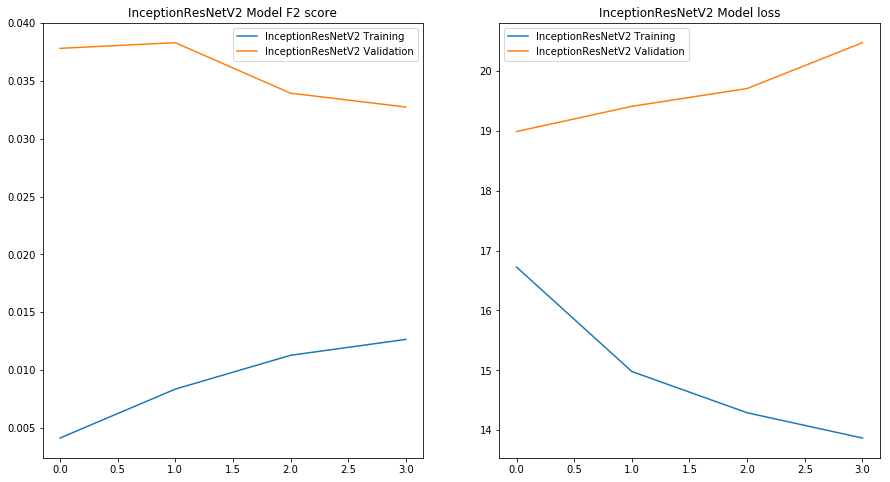

In [14]:
model_name = 'InceptionResNetV2'

fig, ax =plt.subplots(1,2, figsize=(15, 8))
    
ax[0].plot(history.history['f2_score'])
ax[0].plot(history.history['val_f2_score'])
ax[0].set_title(model_name +  ' Model F2 score')
ax[0].legend([model_name +  ' Training',model_name +  ' Validation'])
#ax[0].ylabel('F2 score')
#ax[0].xlabel('epoch')
    
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title(model_name +  ' Model loss')
ax[1].legend([model_name +  ' Training',model_name +  ' Validation'])
#ax[1].ylabel('Loss')
#ax[1].xlabel('epoch')

In [15]:
test_generator.reset()
pred=InceptionResNetV2_model.predict_generator(test_generator,
steps=STEP_SIZE_TEST+1,
verbose=1)

59/59 [==============================] - 54s 920ms/step


pred is of shape  7443 x 1103: 7443 test examples, and 1103 different labels.

Next step: apply threshold, if over a certain threshold, then consider it as a label. Otherwise, not.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


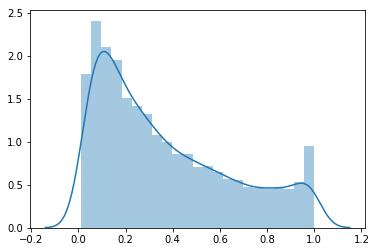

In [16]:
max_of_each_img=[]
for i in range(len(pred)):
    max_of_each_img.append(pred[i].max())
sns.distplot(max_of_each_img)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


threshhold used is:  0.03
There are 171 images without labels


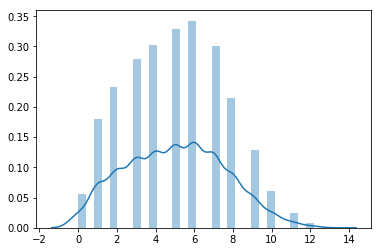

In [31]:
threshold_count = 0.03

nb_label_over_thresh_of_each_img=[]
for i in range(len(pred)):
    nb_labels = 0
    for prediction in range(len(pred[i])):
        if pred[i][prediction]>=threshold_count:
            nb_labels+=1
    nb_label_over_thresh_of_each_img.append(nb_labels)
sns.distplot(nb_label_over_thresh_of_each_img)
print('threshhold used is: ', threshold_count)
print('There are {} images without labels'.format(nb_label_over_thresh_of_each_img.count(nb_label_over_thresh_of_each_img==0)))

In [32]:
import operator

threshold = 0.03

label_for_test_img = []
for i in range(len(pred)):
    #list to store the label number over the threshold
    label_number={}
    for prediction in range(len(pred[i])):
        if pred[i][prediction]>=threshold:
            label_number[prediction] = prediction
    sorted_label_number = sorted(label_number.items(), key=operator.itemgetter(1), reverse=True)
    label_for_test_img.append([i[0] for i in sorted_label_number[:5]])
#    print('for image {} labels are: {}'.format(i, label_number))

label_for_test_img[:10]

[[962, 809, 129, 121, 97],
 [903, 536, 387, 202, 129],
 [1061, 921, 560, 230, 203],
 [897, 203, 157, 129],
 [1053, 895, 449, 230],
 [997, 988, 897, 209, 157],
 [1051, 897, 739, 560, 209],
 [988, 897, 860, 656, 560],
 [1062, 129, 29],
 [860, 797, 739, 656, 636]]

In [33]:
valid_generator.reset()
pred_valid=InceptionResNetV2_model.predict_generator(valid_generator,
                                   steps=STEP_SIZE_VALID+1,
                                   verbose=1)

171/171 [==============================] - 130s 758ms/step


In [34]:
label_for_valid_img = []
for i in range(len(pred_valid)):
    #list to store the label number over the threshold
    label_number={}
    for prediction in range(len(pred_valid[i])):
        if pred_valid[i][prediction]>=threshold:
            label_number[prediction] = prediction
    sorted_label_number = sorted(label_number.items(), key=operator.itemgetter(1), reverse=True)
    label_for_valid_img.append([i[0] for i in sorted_label_number[:5]])
#    print('for image {} labels are: {}'.format(i, label_number))

label_for_valid_img[:10]

[[921, 536],
 [157],
 [557, 202],
 [997, 988, 897, 820, 157],
 [897, 540, 157],
 [636, 609, 560, 203, 157],
 [962, 927, 609, 308, 230],
 [1054, 860, 687, 656, 202],
 [921, 897, 823, 757, 573],
 [1006, 820, 532, 469, 203]]

In [35]:
test_labels["id"]=test_labels["id"].apply(remove_ext)

In [36]:
test_list = pd.Series([list(x) for x in label_for_test_img])
test_str = test_list.apply(lambda x: [str(i) for n,i in enumerate(x)])
test_str = test_str.apply(lambda l: ' '.join(l))

In [37]:
results=pd.DataFrame({"id":test_labels["id"],
                      "attribute_ids":test_str})
results.to_csv("submission.csv",index=False)

In [38]:
results.head()

,id,attribute_ids
0,10023b2cc4ed,962 809 129 121 97
1,100fbe75ed8f,903 536 387 202 129
2,101b627524a0,1061 921 560 230 203
3,10234480c412,897 203 157 129
4,1023b0e2636d,1053 895 449 230
